# Registration

Correct for rigid/non-rigid movement

- Apply the nonrigid motion correction (NoRMCorre) algorithm for motion correction.
- View pre/most correction movie
- Use quality metrics to evaluate registration quality

In [ ]:
# Imports 

%load_ext autoreload
%autoreload 2

from pathlib import Path
import os
import pandas as pd

import mesmerize_core as mc
import numpy as np
import tifffile
from matplotlib import pyplot as plt

from mesmerize_core.caiman_extensions.cnmf import cnmf_cache
import lbm_caiman_python as lcp

if os.name == "nt":
    # disable the cache on windows, this will be automatic in a future version
    cnmf_cache.set_maxsize(0)

pd.options.display.max_colwidth = 120

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### (optional): View hardware information

In [15]:
!pip install cloudmesh-cmd5
!cms help # dont forget to call it after the install as it sets some defaults
!cms sysinfo


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


*** No help on # dont forget to call it after the install as it sets some defaults
+------------------+------------------------------------------------------------------------------------+
| Attribute        | Value                                                                              |
+------------------+------------------------------------------------------------------------------------+
| cpu              |                                                                                    |
| cpu_cores        | 24                                                                                 |
| cpu_count        | 32                                                                                 |
| cpu_threads      | 32                                                                                 |
| date             | 2024-11-26 16:29:03.580714                                                         |
| frequency        | scpufreq(current=3200.0, min=0.0, max=3200.0)   

### Data path setup

We set 2 path variables:

1. `data_path` : input, path where you saved the output from the assembly step
2. `batch_path` : results, can be anywhere you please, must end in .pickle

```{note}
This notebook assumes you saved scans as TIFF with `join_contiguous=True` so filenames are `plane_N.tiff`
The process for `join_contiguous=False` is the same, but with the roi attached to the filename `plane_N_roi_M`.
```
To simplify data management, we put our batch_path (which stores results) in the same directory as our raw data.

In [16]:
parent_path = Path().home() / "caiman_data"
data_path = parent_path / 'out2'  # where the output files from the assembly step are located
batch_path = data_path / 'batch.pickle'

In [20]:
tiff_files = [x for x in Path(data_path).glob('*.tif*')]
tiff_files

[PosixPath('/home/flynn/caiman_data/out2/plane_21.tiff'),
 PosixPath('/home/flynn/caiman_data/out2/plane_1.tiff'),
 PosixPath('/home/flynn/caiman_data/out2/plane_16.tiff')]

### Load a data file to examine

In [30]:
file = tiff_files[1]
data = tifffile.imread(file)
data.shape

(1000, 600, 576)

## View metadata

`lcp.get_metadata(filepath)` works on raw scanimage files and files processed through `lcp.save_as()`

In [31]:
metadata = lcp.get_metadata(file)
metadata

{'image_height': 2478,
 'image_width': 145,
 'num_pages': 51900,
 'ndim': 3,
 'dtype': 'uint16',
 'size': 18648189000,
 'shape': [51900, 2478, 145],
 'num_planes': 30,
 'num_rois': 4,
 'num_frames': 1730.0,
 'frame_rate': 9.60806,
 'fov': [150, 600],
 'pixel_resolution': [1.04, 1.0],
 'roi_width_px': 144,
 'roi_height_px': 600,
 'sample_format': 'int16',
 'num_lines_between_scanfields': 24,
 'center_xy': [-1.428571429, 0],
 'line_period': 4.15652e-05,
 'size_xy': [0.9523809524, 3.80952381],
 'objective_resolution': 157.5}

## Registration parameters

Here’s a markdown table describing the parameters:

| Parameter               | Description                                                                                     | Value/Default                  |
|-------------------------|-------------------------------------------------------------------------------------------------|--------------------------------|
| `dxy`                  | Spatial resolution (pixel size in micrometers).                                                 | `dxy` (from metadata)           |
| `fr`                   | Frame rate of the video (frames per second).                                                    | `fr` (from metadata)            |
| `max_shifts`           | Maximum allowed rigid shift in pixels for motion correction.                                     | `(int(10/dxy), int(10/dxy))`   |
| `strides`              | Size of patches for motion correction.                                                          | `[48, 48]`                     |
| `overlaps`             | Overlap between patches for motion correction.                                                  | `[24, 24]`                     |
| `max_deviation_rigid`  | Maximum allowed deviation for patches relative to rigid shifts.                                  | `3`                            |
| `border_nan`           | How to handle border values during motion correction.                                            | `'copy'`                       |
| `pw_rigid`             | Flag indicating whether to perform piecewise rigid motion correction.                            | `False`                        |
| `gSig_filt`            | Size of the Gaussian filter for smoothing the motion correction process.                         | `(3, 3)`                       |
| `shifts_opencv`        | Flag to use bicubic interpolation for motion correction.                                         | `True`                         |

The parameters are passed **directly** to `caiman`, this means you need to use the same exact names for the parameters and you can use all the parameters that you can use with `caiman` - because it's just passing them to `caiman`.

The parameters dict for a mesmerize batch item must have the following structure. Put all the parameters in a dict under a key called **main**. The **main** dict is then fed directly to `caiman`.

```python
{"main": {... params directly passed to caiman}}
```

### Parameters from metadata

```{note}
We want our parameters to physically make sense. 
For example, `max_shifts` is the maximum allowed *rigid* shift in pixels.
We don't want to shift any pixels more than a full neuron or we will introduce artifacts between frames.
```

In [32]:
dxy = metadata['pixel_resolution']
print(f"Pixel resolution: {dxy[0]} um/px, {dxy[1]} um/px")

Pixel resolution: 1.04 um/px, 1.0 um/px


In [33]:
# note this is only for a single ROI
fov = metadata['fov']
print(f"Field of View: {fov[0]}px, {fov[1]}px")

Field of View: 150px, 600px


In [34]:
fr = metadata['frame_rate']
print(f"Frame rate: {fr} Hz")

Frame rate: 9.60806 Hz


## Preview data with scalebars

`plot_data_with_scalebars` will give you 3 images, at 5, 10 and 20 um. Take note of the approximate size of the neurons in your data.

You can use a single frame:

```python
plot_with_scalebars(data[0, :, :], np.mean(dxy))
```
A mean image:

```python
plot_with_scalebars(np.mean(data, axis=0), np.mean(dxy))
```

or, the maximum-projection image as displayed below.


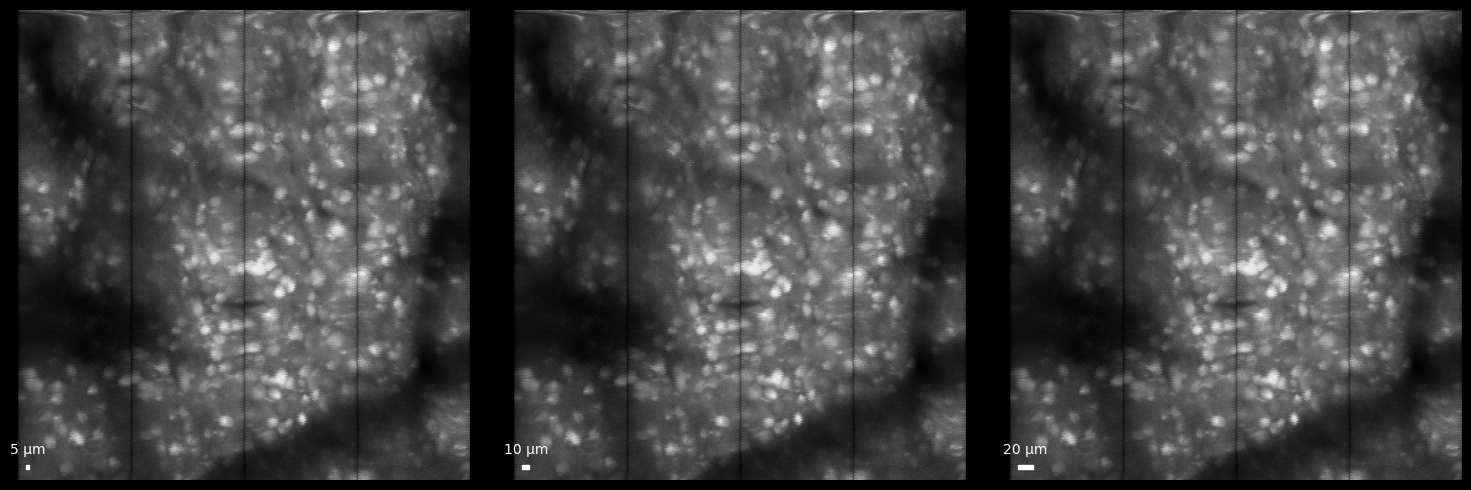

In [36]:
from lbm_caiman_python import plot_with_scalebars

# plot_with_scalebars(data[0, :, :], np.mean(dxy))
plot_with_scalebars(np.max(data, axis=0), np.mean(dxy))

## Visualize patches

The `generate_patch_view` function divides the image into patches the same way CaImAn does internally.

Increasing / decreasing the `target_patch_size` and `overlap_fraction` parameters to examine the effect of different stride/overlap values displayed in the title. 

In general, you want patches to encompass at least the size of a full neuron and generally 2-3x the neuron size.


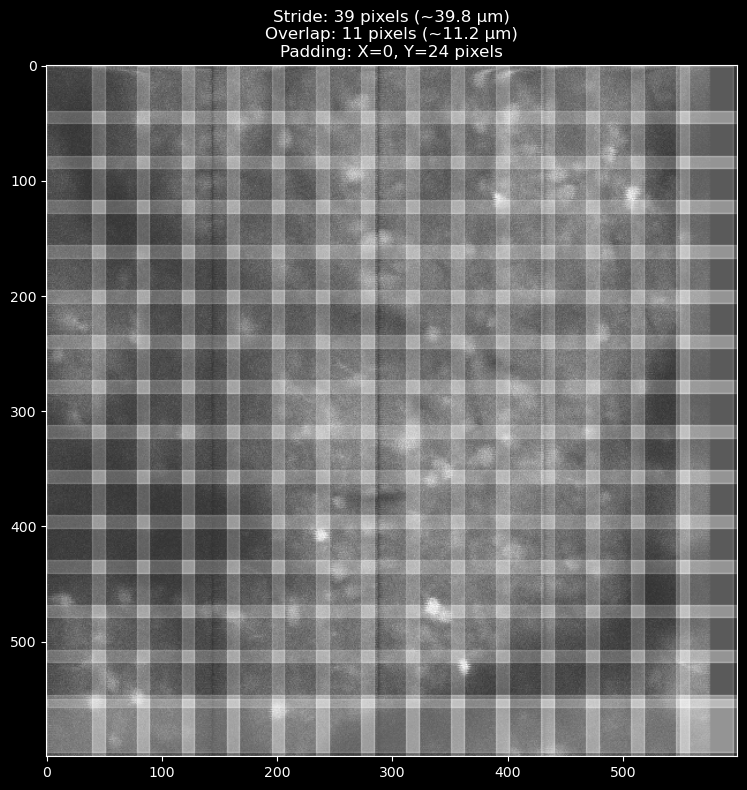

In [37]:
from lbm_caiman_python import generate_patch_view
# this function assumes a square pixel resolution, so take the mean
fig, ax = generate_patch_view(data[0, :, :], pixel_resolution=np.mean(dxy), target_patch_size=40, overlap_fraction=0.3) # defaults
plt.show()

## Create the parameters we pass to CaImAn

The above patch view looks good, so we use those values in our parameters dictionary.

You *can* also include segmentation parameters in this dictionary if you wish. This is *not recommmended* as several parameters share similar names yet perform different actions. i.e:
-  `stride` and `gSig_filt` parameters are for registration
-  `strides` for `gSig` are parameters for segmentation

In [38]:
max_shift = 30                                  # pixels
max_shifts = (int(max_shift), int(max_shift))   # maximum allowed rigid shift in pixels (view the movie to get a sense of motion)
max_deviation_rigid = 3               # maximum deviation allowed for patch with respect to rigid shifts
pw_rigid = True                       # flag for performing rigid or piecewise rigid motion correction
shifts_opencv = True                  # flag for correcting motion using bicubic interpolation (otherwise FFT interpolation is used)
border_nan = 'copy'                   # replicate values along the boundary (if True, fill in with NaN)

mcorr_params = {
    'main':  # this key is necessary for specifying that these are the "main" params for the algorithm
    {
        'dxy': dxy,
        'fr': fr,
        'max_shifts': max_shifts, # make sure its a tuple/list of integers 
        'strides': [39, 39],
        'overlaps': [11, 11],
        'max_deviation_rigid': 3,
        'border_nan':border_nan,
        'pw_rigid': pw_rigid,
        'gSig_filt': (3, 3),
    },
}

### Run registration with `mesmerize-core`

See the mesmerize-core [utility docs](https://mesmerize-core.readthedocs.io/en/latest/api/functions.html) for more information on batch creation.


### Create or load a batch set

```{warning}
In the below if-else clause, be careful if you expect a batch to exist, a typo can be deceiving!
```

In [39]:
# Create or load a batch results file
# To overwrite:
# df = mc.create_batch(batch_path, remove_existing=True)

if not batch_path.exists():
    df = mc.create_batch(batch_path)
else:
    df = mc.load_batch(batch_path)

# tell mesmerize where the raw data is
mc.set_parent_raw_data_path(data_path)
df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid


### Add an item to the batch

A "batch item" consists of:
* algorithm to run, `algo` 
    - currently: mcorr, cnmf, cnmfe
* input movie to run the algorithm on, `input_movie_path`
    - can be string or dataframe row
* parameters for the specified algorithm, `params`
* a name for you to keep track of things `item_name`
    - can be anything

In [ ]:
df.caiman.add_item(
    algo='mcorr',
    input_movie_path=file,
    params=mcorr_params,
    item_name='mcorr',  
)
df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,mcorr,plane_1.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (30, 30), 'strides': (39, 39), 'overlaps': (11, 11), 'max...",None,2024-12-01T17:41:16,None,None,None,0393cf1f-f193-4fa5-9707-188c891dc68c


## First registration run

```{note}
On Linux & Mac it will run in subprocess but on Windows it will run in the local kernel.
For this reason, on windows you need to reload the dataframe:
```
```python
df=df.caiman.reload_from_disk()
df
```

If you ever get errors like 

```python
TypeError: NoneType is not subscriptable
```
**This likely means you need to reload the dataframe**.

In [41]:
df.iloc[0].caiman.run()

starting mc


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.


mc finished successfully!
computing projections
Computing correlation image


100%|██████████| 1/1 [00:02<00:00,  2.96s/it]


finished computing correlation image


<Popen: returncode: 0 args: '/home/flynn/caiman_data/out2/0393cf1f-f193-4fa5...>

In [43]:
df=df.caiman.reload_from_disk()
df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,mcorr,plane_1.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (30, 30), 'strides': (39, 39), 'overlaps': (11, 11), 'max...",{'mean-projection-path': 0393cf1f-f193-4fa5-9707-188c891dc68c/0393cf1f-f193-4fa5-9707-188c891dc68c_mean_projection.n...,2024-12-01T17:41:16,2024-12-01T17:42:16,54.1 sec,None,0393cf1f-f193-4fa5-9707-188c891dc68c


### Check for errors in outputs

In the table header **outputs**, you should see 

```python
{'mean-projection-path': ...}
```
If you see instead:

```python
{'success': False, ...}
```

Run the below cell to evaluate the error message.

In [44]:
import pprint
pprint.pprint(df.iloc[-1].outputs["traceback"])

None


## Evaluate motion correction outputs with `mesmerize-core` API 

mesmerize-core offers an easy [API](https://mesmerize-core.readthedocs.io/en/latest/api/mcorr.html) to retrieve results from the batch dataframe.

In [45]:
index = 0

# get the motion corrected movie memmap
mcorr_movie = df.iloc[0].mcorr.get_output()
mcorr_shifts = df.iloc[0].mcorr.get_shifts()

# path to the mcorr memmap if you ever need it
mcorr_memmap_path = df.iloc[0].mcorr.get_output_path()

# mean projection, max and std projections are also available
mean_proj = df.iloc[0].caiman.get_projection("mean")

# the input movie, note that we use `.caiman` here instead of `.mcorr`
input_movie = df.iloc[0].caiman.get_input_movie()

### Side-by-side with `fastplotlib`

Its helpful to zoom into specific locations of your images to see improvements.

RFBOutputContext()

JupyterWgpuCanvas(css_height='560px', css_width='900px')
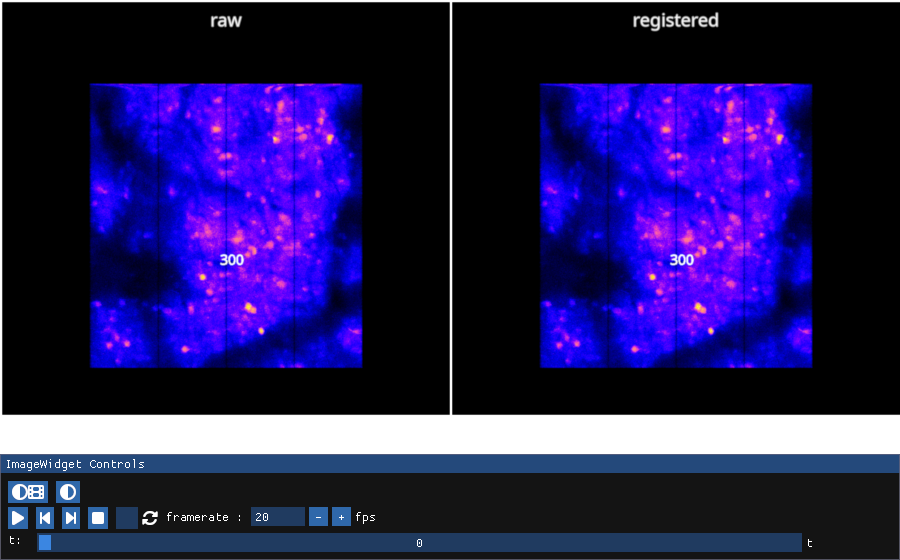

No such comm: 3c78dee3e44a41e8b694fa20f61edb6e
No such comm: 3c78dee3e44a41e8b694fa20f61edb6e


In [53]:
import fastplotlib as fpl

mcorr_iw = fpl.ImageWidget(
    data=[input_movie, mcorr_movie],
    names=['raw', 'registered'],
    cmap="gnuplot2",
    window_funcs={},
    figure_kwargs={"size": (900, 560)},
    histogram_widget=False, # helps keep plots close together 
)
mcorr_iw.show()

In [54]:
mcorr_iw.close()

In [ ]:
from ipywidgets import Tab, Text, Button, VBox, interact_manual, interactive
@interact_manual(parent_path=str(parent_path), batch_path=str(batch_path))
def start_widget(parent_path, batch_path):
    mc.set_parent_raw_data_path(parent_path)

    df = mc.load_batch(batch_path)

    tab = Tab()

    # mcorr_container = df.mcorr.viz()
    mcorr_container = df.mcorr.viz(start_index=0)

    tab.children = [mcorr_container.show()]
    tab.titles = ["mcorr"]
    display(tab)

## Parameter Grid Search (if you need it!)

More runs with varying parameters, stored on disk in the dataframe batch.pickle

In [55]:
# copy the mcorr_params2 dict to make some changes
# some variants of max_shifts
from copy import deepcopy

for shifts in [2,32]:
    for strides in [12,64]:
        overlaps = int(strides / 2)
        # deep copy is the safest way to copy dicts
        new_params = deepcopy(mcorr_params)

        # assign the "max_shifts"
        new_params["main"]["pw_rigid"] = True
        new_params["main"]["max_shifts"] = (shifts, shifts)
        new_params["main"]["strides"] = (strides, strides)
        new_params["main"]["overlaps"] = (overlaps, overlaps)

        df.caiman.add_item(
            algo='mcorr',
            input_movie_path=file,
            params=new_params,
            item_name='mcorr',  # filename of the movie, but can be anything
        )

df.caiman.reload_from_disk()

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,mcorr,plane_1.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (30, 30), 'strides': (39, 39), 'overlaps': (11, 11), 'max...",{'mean-projection-path': 0393cf1f-f193-4fa5-9707-188c891dc68c/0393cf1f-f193-4fa5-9707-188c891dc68c_mean_projection.n...,2024-12-01T17:41:16,2024-12-01T17:42:16,54.1 sec,None,0393cf1f-f193-4fa5-9707-188c891dc68c
1,mcorr,mcorr,plane_1.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (12, 12), 'overlaps': (6, 6), 'max_dev...",None,2024-12-01T18:10:05,None,None,None,a8f0f15d-d2a7-4ab8-92d1-9dc05ebcbc89
2,mcorr,mcorr,plane_1.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (64, 64), 'overlaps': (32, 32), 'max_d...",None,2024-12-01T18:10:05,None,None,None,1fc13802-a0bf-46bf-9444-18ccda730c7a
3,mcorr,mcorr,plane_1.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (32, 32), 'strides': (12, 12), 'overlaps': (6, 6), 'max_d...",None,2024-12-01T18:10:05,None,None,None,37be64bc-5273-43f1-af8d-6d865434eb39
4,mcorr,mcorr,plane_1.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (32, 32), 'strides': (64, 64), 'overlaps': (32, 32), 'max...",None,2024-12-01T18:10:05,None,None,None,14c54a52-45c1-4d67-bb1e-89e0ae4b4883


### Use the varients to organize results to run multiple batch items.

`df.iterrows()` iterates through rows and returns the numerical index and row for each iteration

In [56]:
for i, row in df.iterrows():
    if row["outputs"] is not None: # item has already been run
        continue # skip

    process = row.caiman.run()

    # on Windows you MUST reload the batch dataframe after every iteration because it uses the `local` backend.
    # this is unnecessary on Linux & Mac
    # "DummyProcess" is used for local backend so this is automatic
    if process.__class__.__name__ == "DummyProcess":
        df = df.caiman.reload_from_disk()

starting mc


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.


mc finished successfully!
computing projections
Computing correlation image


100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


finished computing correlation image
starting mc


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.


mc finished successfully!
computing projections
Computing correlation image


100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


finished computing correlation image
starting mc


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.


mc finished successfully!
computing projections
Computing correlation image


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


finished computing correlation image
starting mc


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.


mc finished successfully!
computing projections
Computing correlation image


100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


finished computing correlation image


### Distinguishing parameter variants

We can see that there are many parameter variants, but it is not easy to see the differences in parameters between the rows that have the same `item_name`.

We can use the `caiman.get_params_diffs()` to see the unique parameters between rows with the same `item_name`

In [57]:
diffs = df.caiman.get_params_diffs(algo="mcorr", item_name=df.iloc[0]["item_name"])
diffs

,max_shifts,overlaps,strides
0,"(30, 30)","(11, 11)","(39, 39)"
1,"(2, 2)","(6, 6)","(12, 12)"
2,"(2, 2)","(32, 32)","(64, 64)"
3,"(32, 32)","(6, 6)","(12, 12)"
4,"(32, 32)","(32, 32)","(64, 64)"


## Quality metrics: correlation, projections, pixel shifts

Create a couple of summary images of the movie, including:
- maximum projection (the maximum value of each pixel) 
- correlation image (how correlated each pixel is with its neighbors)

If a pixel comes from an active neural component it will tend to be highly correlated with its neighbors.

In [64]:
plane = 1

df = df.caiman.reload_from_disk()

# first item is just the raw movie

movies = [df.iloc[0].caiman.get_input_movie()]

subplot_names = ["raw"]

means = [df.iloc[0].caiman.get_projection("mean")]
shifts = [df.iloc[0].mcorr.get_shifts("mean")]

# get the param diffs to set plot titles
param_diffs = df.caiman.get_params_diffs("mcorr", item_name=df.iloc[0]["item_name"])

# add all the mcorr outputs to the list
for i, row in df.iterrows():

    if row.algo != 'mcorr':
        continue

    # add to the list of movies to plot
    movies.append(row.mcorr.get_output())

    max_shifts = param_diffs.iloc[i]["max_shifts"][0]
    strides = param_diffs.iloc[i]["strides"][0]
    overlaps = param_diffs.iloc[i]["overlaps"][0]

    # subplot title to show dataframe index
    subplot_names.append(f"ix {i}: max_sh: {max_shifts}, str: {strides}, ove: {overlaps}")

    # mean images which we'll use later
    means.append(row.caiman.get_projection("mean"))
    shifts.append(row.mcorr.get_shifts())

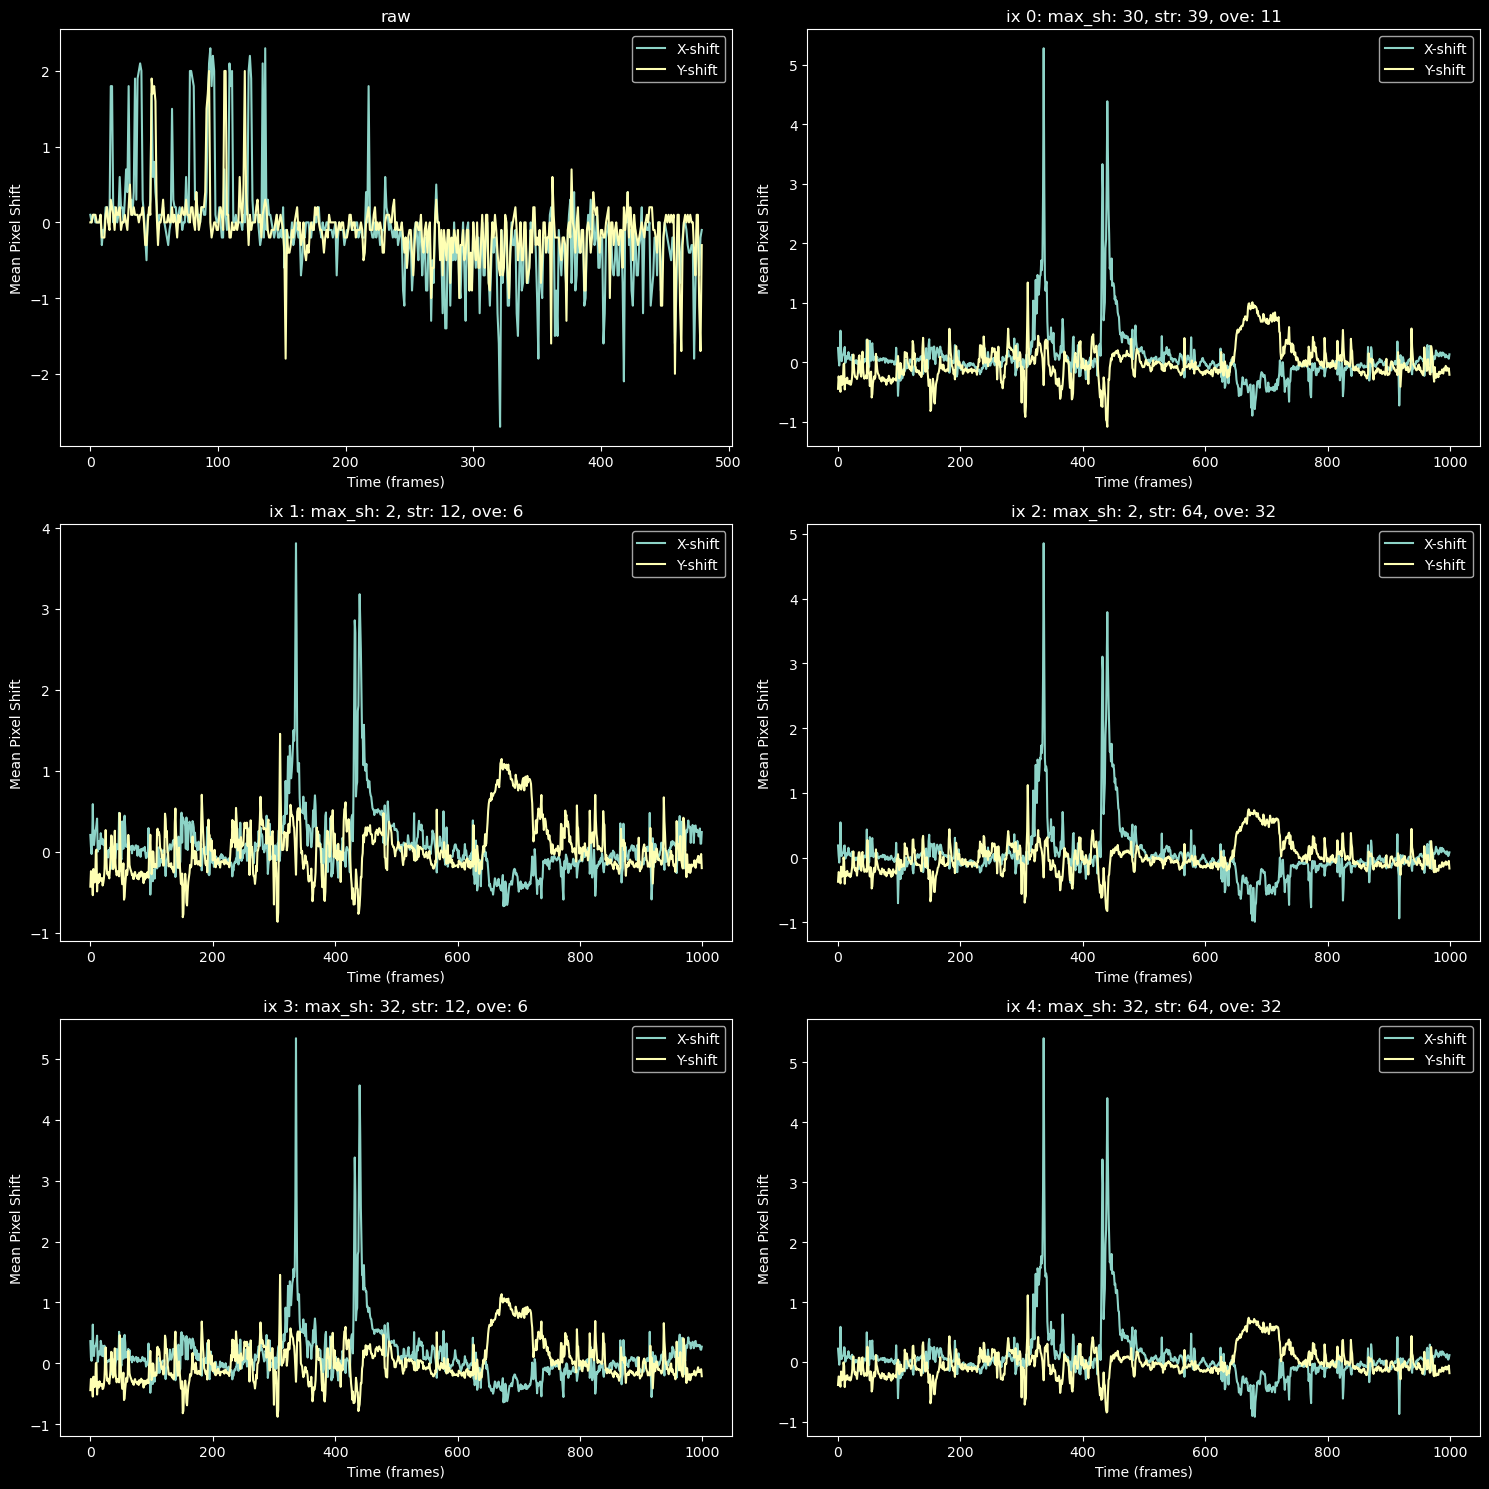

In [70]:
# Prepare the 3x3 figure
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.ravel()

# Plot shifts for each movie
for idx, (shift, ax, name) in enumerate(zip(shifts, axes, subplot_names)):
    if len(shift) > plane:  # Check for multi-plane data
        shift_plane = shift[plane]
    else:
        shift_plane = shift

    shiftsx = [x[0] for x in shift_plane]
    shiftsy = [x[1] for x in shift_plane]
    shiftsx_mean = [np.mean(x) for x in shiftsx]
    shiftsy_mean = [np.mean(y) for y in shiftsy]
    xr = list(range(len(shiftsx_mean)))

    # Plot mean shifts with labels
    ax.plot(xr, shiftsx_mean, label="X-shift")
    ax.plot(xr, shiftsy_mean, label="Y-shift")
    ax.set_title(name)
    ax.set_xlabel("Time (frames)")
    ax.set_ylabel("Mean Pixel Shift")
    ax.legend()

# Adjust layout for better visibility
plt.tight_layout()
plt.show()

RFBOutputContext()

JupyterWgpuCanvas(css_height='700px', css_width='900px')
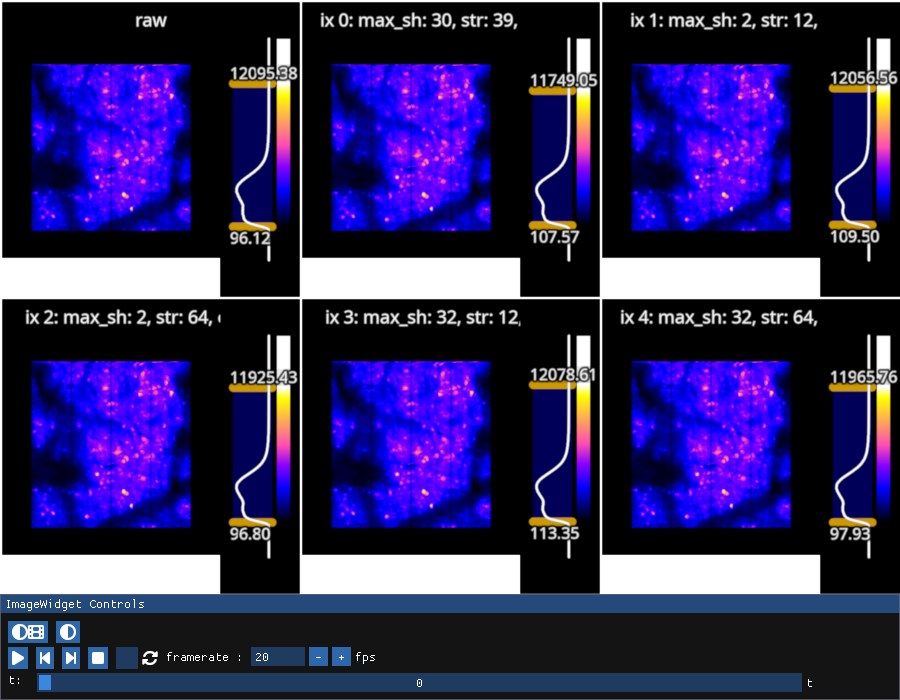

In [ ]:
# create the widget
mcorr_iw_multiple = fpl.ImageWidget(
    data=movies,  # list of movies
    window_funcs={"t": (np.mean, 17)}, # window functions as a kwarg, this is what the slider was used for in the ready-made viz
    figure_kwargs={"size": (900, 700)},
    names=subplot_names,  # subplot names used for titles
    cmap="gnuplot2"
)

# free up some space
for subplot in mcorr_iw_multiple.figure:
    subplot.docks["right"].size = 0

mcorr_iw_multiple.show()

In [ ]:
mcorr_iw_multiple.window_funcs["t"].window_size = 13

In [ ]:
mcorr_iw_multiple.close()

### Optional, cleanup DataFrame

Use the index that works best and all other items.

Remove batch items (i.e. rows) using `df.caiman.remove_item(<item_uuid>)`. This also cleans up the output data in the batch directory.

**Note:** On windows calling `remove_item()` will raise a `PermissionError` if you have the memmap file open. The workaround is to shutdown the current kernel and then use `df.caiman.remove_item()`. For example, you can keep another notebook that you use just for cleaning unwanted mcorr items.

There is currently no way to close a `numpy.memmap`: https://github.com/numpy/numpy/issues/13510

Indices are always reset when you use `caiman.remove_item()`. UUIDs are always preserved.

In [78]:
df=df.caiman.reload_from_disk()
df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,mcorr,plane_1.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (30, 30), 'strides': (39, 39), 'overlaps': (11, 11), 'max...",{'mean-projection-path': 0393cf1f-f193-4fa5-9707-188c891dc68c/0393cf1f-f193-4fa5-9707-188c891dc68c_mean_projection.n...,2024-12-01T17:41:16,2024-12-01T17:42:16,54.1 sec,None,0393cf1f-f193-4fa5-9707-188c891dc68c
1,mcorr,mcorr,plane_1.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (12, 12), 'overlaps': (6, 6), 'max_dev...",{'mean-projection-path': a8f0f15d-d2a7-4ab8-92d1-9dc05ebcbc89/a8f0f15d-d2a7-4ab8-92d1-9dc05ebcbc89_mean_projection.n...,2024-12-01T18:10:05,2024-12-01T18:13:10,170.19 sec,None,a8f0f15d-d2a7-4ab8-92d1-9dc05ebcbc89
2,mcorr,mcorr,plane_1.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (64, 64), 'overlaps': (32, 32), 'max_d...",{'mean-projection-path': 1fc13802-a0bf-46bf-9444-18ccda730c7a/1fc13802-a0bf-46bf-9444-18ccda730c7a_mean_projection.n...,2024-12-01T18:10:05,2024-12-01T18:14:03,48.45 sec,None,1fc13802-a0bf-46bf-9444-18ccda730c7a
3,mcorr,mcorr,plane_1.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (32, 32), 'strides': (12, 12), 'overlaps': (6, 6), 'max_d...",{'mean-projection-path': 37be64bc-5273-43f1-af8d-6d865434eb39/37be64bc-5273-43f1-af8d-6d865434eb39_mean_projection.n...,2024-12-01T18:10:05,2024-12-01T18:16:59,172.54 sec,None,37be64bc-5273-43f1-af8d-6d865434eb39
4,mcorr,mcorr,plane_1.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (32, 32), 'strides': (64, 64), 'overlaps': (32, 32), 'max...",{'mean-projection-path': 14c54a52-45c1-4d67-bb1e-89e0ae4b4883/14c54a52-45c1-4d67-bb1e-89e0ae4b4883_mean_projection.n...,2024-12-01T18:10:05,2024-12-01T18:17:50,48.04 sec,None,14c54a52-45c1-4d67-bb1e-89e0ae4b4883


In [79]:
rows_keep = [1]
for i, row in df.iterrows():
    if i not in rows_keep:
        df.caiman.remove_item(row.uuid, safe_removal=False)
df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,mcorr,plane_1.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (12, 12), 'overlaps': (6, 6), 'max_dev...",{'mean-projection-path': a8f0f15d-d2a7-4ab8-92d1-9dc05ebcbc89/a8f0f15d-d2a7-4ab8-92d1-9dc05ebcbc89_mean_projection.n...,2024-12-01T18:10:05,2024-12-01T18:13:10,170.19 sec,None,a8f0f15d-d2a7-4ab8-92d1-9dc05ebcbc89


In [80]:
df.caiman.save_to_disk()

## Apply registration using the same parameters to the remaining files

In [77]:
# reminder, this contains our files
tiff_files

[PosixPath('/home/flynn/caiman_data/out2/plane_21.tiff'),
 PosixPath('/home/flynn/caiman_data/out2/plane_1.tiff'),
 PosixPath('/home/flynn/caiman_data/out2/plane_16.tiff')]

In [ ]:
best_parameter_index = 0 # change this if you have multiple items in your batch
for i in range(len(tiff_files)):
    print(f'Processing: {tiff_files[i]}')
    df.caiman.add_item(
        algo='mcorr',
        input_movie_path=tiff_files[i],
        params= df.iloc[best_parameter_index].params,
        item_name=f'plane_{i}',  # filename of the movie, but can be anything
    )

Processing: /home/flynn/caiman_data/out2/plane_21.tiff
Processing: /home/flynn/caiman_data/out2/plane_1.tiff
Processing: /home/flynn/caiman_data/out2/plane_16.tiff


In [82]:
df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,mcorr,plane_1.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (12, 12), 'overlaps': (6, 6), 'max_dev...",{'mean-projection-path': a8f0f15d-d2a7-4ab8-92d1-9dc05ebcbc89/a8f0f15d-d2a7-4ab8-92d1-9dc05ebcbc89_mean_projection.n...,2024-12-01T18:10:05,2024-12-01T18:13:10,170.19 sec,None,a8f0f15d-d2a7-4ab8-92d1-9dc05ebcbc89
1,mcorr,plane_0,plane_21.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (12, 12), 'overlaps': (6, 6), 'max_dev...",None,2024-12-01T18:48:52,None,None,None,2918ff63-f204-4334-8837-ea172af89e39
2,mcorr,plane_1,plane_1.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (12, 12), 'overlaps': (6, 6), 'max_dev...",None,2024-12-01T18:48:52,None,None,None,c35039bb-fe19-43a8-9bcc-8d28f3b332d5
3,mcorr,plane_2,plane_16.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (12, 12), 'overlaps': (6, 6), 'max_dev...",None,2024-12-01T18:48:52,None,None,None,245bb955-feb9-4245-86bf-dd6ec1c79e95


In [83]:
# dont process the same file twice!
df.caiman.remove_item(2)
df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,mcorr,plane_1.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (12, 12), 'overlaps': (6, 6), 'max_dev...",{'mean-projection-path': a8f0f15d-d2a7-4ab8-92d1-9dc05ebcbc89/a8f0f15d-d2a7-4ab8-92d1-9dc05ebcbc89_mean_projection.n...,2024-12-01T18:10:05,2024-12-01T18:13:10,170.19 sec,None,a8f0f15d-d2a7-4ab8-92d1-9dc05ebcbc89
1,mcorr,plane_0,plane_21.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (12, 12), 'overlaps': (6, 6), 'max_dev...",None,2024-12-01T18:48:52,None,None,None,2918ff63-f204-4334-8837-ea172af89e39
2,mcorr,plane_2,plane_16.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (12, 12), 'overlaps': (6, 6), 'max_dev...",None,2024-12-01T18:48:52,None,None,None,245bb955-feb9-4245-86bf-dd6ec1c79e95


In [84]:
for i, row in df.iterrows():
    if row["outputs"] is not None: # item has already been run
        continue # skip

    process = row.caiman.run()

    # on Windows you MUST reload the batch dataframe after every iteration because it uses the `local` backend.
    # this is unnecessary on Linux & Mac
    # "DummyProcess" is used for local backend so this is automatic
    if process.__class__.__name__ == "DummyProcess":
        df = df.caiman.reload_from_disk()

starting mc


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.


mc finished successfully!
computing projections
Computing correlation image


100%|██████████| 1/1 [00:06<00:00,  6.96s/it]


finished computing correlation image
starting mc


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.


mc finished successfully!
computing projections
Computing correlation image


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


finished computing correlation image
